# Technique assesment in real-time

- Note
    - full_dataのメモリサイズは88kBくらい
    - 検出箇所はframe_legthの分だけ前にずれる

In [1]:
import sounddevice as sd
import numpy as np
import socket
import librosa
import sys
import math
import matplotlib.pyplot as plt
import time as ti
import threading

import tensorflow
from tensorflow import keras
from keras.models import load_model

In [253]:
model = load_model("./../models/guitar_.08_0.0511_0.9567.hdf5")

In [2]:
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def min_max_normalize(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

In [200]:
def onset_detection(y, sr, frame_length, hop_length, params):
    rms = librosa.feature.rms(y=y*100, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=params["pre_max"], post_max=params["post_max"], pre_avg=params["pre_avg"], post_avg=params["post_avg"], delta=params["delta"], wait=params["wait"])
    times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
    return onset_envelope, onset_frames, times

In [256]:
def create_array(full_data, detected_num):
    window_size = 22050
    front_padding = 22050
    back_padding = 44100
    result = []

    for i in detected_num:
        start = max(0, i - front_padding)
        end = min(len(full_data), i + back_padding)

        if end - start < front_padding + back_padding:
            # Padding if the window size is not fully covered
            padding_start = max(0, front_padding - i)
            padding_end = max(0, back_padding - (len(hoge) - i))
            cliped_data = np.pad(full_data[start:end], (padding_start, padding_end), mode='constant')
        else:
            cliped_data = full_data[start:end]

        result.append(cliped_data)

    return np.array(result)

In [261]:
def predict_performances(y, model):
    x = y.reshape(len(y))
    melsp = calculate_melsp(x)
    
    pred = model.predict(melsp.reshape(1, 128, 517, 1))
    pred_label = np.argmax(pred)
        
    if pred_label == 0:
        return "good!!"
    elif pred_label == 1:
        return "normal"
    elif pred_label == 2:
        return "bad!!"

In [266]:
sr = 22050
data_length = 1
data = np.zeros(int(sr)*data_length, dtype=np.float32)
onset_frames = []
detected_onset_times = []
non_negative_data = np.zeros(int(sr), dtype=np.float32)
shift_size = 576
#shift_size = 1136
hop_length = 1024
frame_length = 2048
pre_max = 30 / 1000 * sr // hop_length
post_max = 0 / 1000 * sr // hop_length + 1
pre_avg = 100 / 1000 * sr // hop_length
post_avg = 100 / 1000 * sr // hop_length + 1
wait = 300 / 1000 * sr // hop_length
#delta = 0.07
delta = 0.4


def callback_pitch(indata, frames, time, status):
    global data, onset_frames, non_negative_data, start_time, full_data
    data = np.roll(data, -shift_size, axis=0)
    data[-shift_size:] = indata.reshape((shift_size,))
    #all_data_list.append(indata.reshape((shift_size,)).copy())
    full_data = np.roll(full_data, -shift_size, axis=0)
    full_data[-shift_size:] = indata.reshape((shift_size,))

    src = data.reshape(data.size) * 100
    rms = librosa.feature.rms(y=src, frame_length=frame_length, hop_length=hop_length, center=False)
    onset_envelope = rms[0, 1:] - rms[0, :-1]
    onset_envelope = np.maximum(0.0, onset_envelope)
    onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)
    
    if len(onset_frames) != 0:
        _times = librosa.times_like(onset_envelope, sr=sr, hop_length=hop_length)
        for onset_frame in onset_frames:
            elapsed_time = (ti.time() - start_time) - (data_length - _times[onset_frame])
            
            if any(abs(elapsed_time - t) < 1.0 for t in detected_onset_times):
                continue
                
            detected_onset_times.append(elapsed_time)
            
            print(f"detect onset: {elapsed_time}")


input_device = int(input("input device number: "))
output_device = int(input("output device number: "))

sd.default.device = [input_device, output_device]

print("input device: ", sd.query_devices(kind="input")["name"], "\n")
print("output device: ", sd.query_devices(kind="output")["name"], "\n")

duration = int(input("duratino: "))

full_data = np.zeros(int(sr)*duration, dtype=np.float32)

with sd.InputStream(
            samplerate=sr,
            channels=1,
            dtype='float32',
            callback=callback_pitch
        ):
        start_time = ti.time()
        sd.sleep(int(duration * 1000))
        print(ti.time() - start_time)

input device number:  1
output device number:  10


input device:  Mic | Line 1/2 (Audient EVO4) 

output device:  Speaker (Realtek(R) Audio) 



duratino:  10


detect onset: 1.8106824760047757
detect onset: 3.3900678094011854
detect onset: 4.842788875540909
detect onset: 6.304584205588516
detect onset: 7.764702260932144
detect onset: 9.204360187491591
10.006611108779907


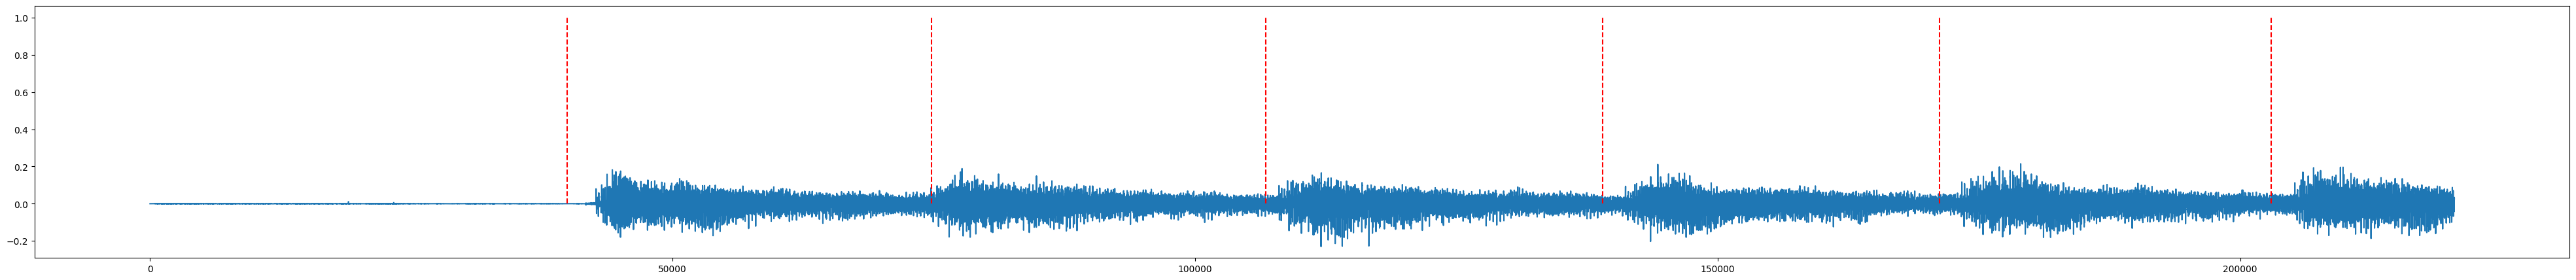

In [267]:
dst = [int(detected_time * sr) for detected_time in detected_onset_times]
full_data_n = min_max_normalize(full_data)
fig = plt.figure(figsize=(50, 5))
ax = fig.add_subplot(111)

ax.plot(full_data, label='onset envelope')
ax.vlines(dst, 0, 1, color='r', linestyle='--', label='onsets')
plt.show()

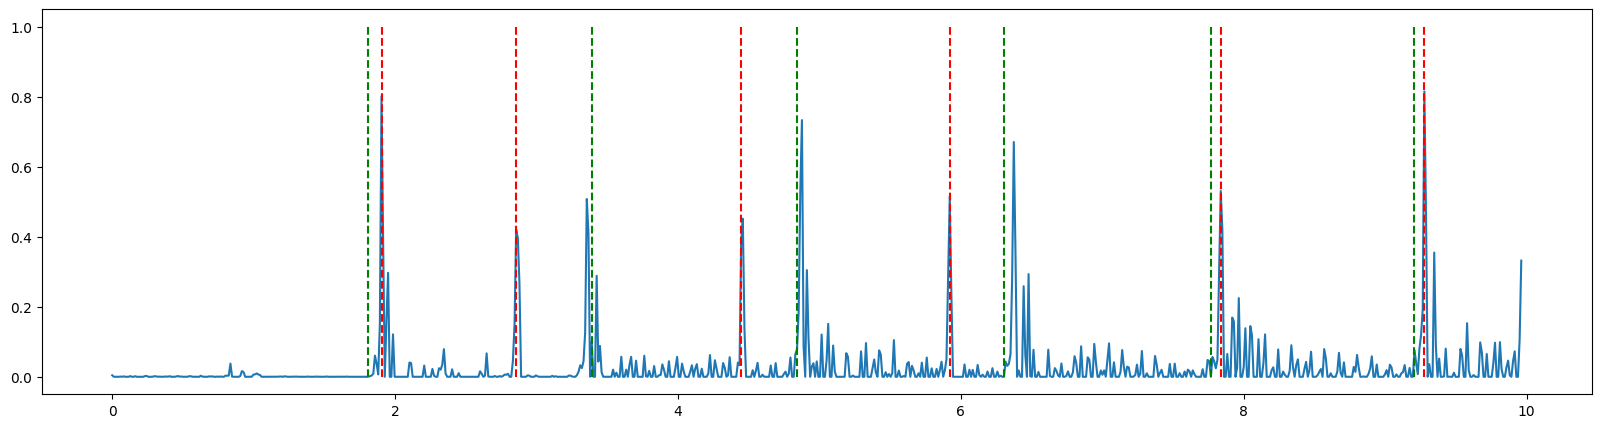

In [268]:
sr = 22050
frame_length=512
hop_length = 256
params = {
"pre_max":30 / 1000 * sr // hop_length,
"post_max":0 / 1000 * sr // hop_length + 1,
"pre_avg":100 / 1000 * sr // hop_length,
"post_avg":100 / 1000 * sr // hop_length + 1,
"wait":600 / 1000 * sr // hop_length,
"delta":0.3
}

harmonic, percussive = librosa.effects.hpss(full_data)
onset_envelope, onset_frames, times = onset_detection(y=percussive, sr=sr, frame_length=frame_length, hop_length=hop_length, params=params)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

ax.plot(times, onset_envelope, label='onset envelope')
ax.vlines(times[onset_frames], 0, 1, color='r', linestyle='--', label='onsets')
ax.vlines(detected_onset_times, 0, 1, color='g', linestyle='--', label='onsets')

plt.show()

In [269]:
detected_num = [int((detected_onset_time * sr) + frame_length) for detected_onset_time in detected_onset_times]

cliped_datas = create_array(full_data, detected_num)

In [270]:
dst = cliped_datas[0]

In [271]:
for dst in cliped_datas:
    result = predict_performances(dst, model)
    print(result)

1/1 [==============================] - 0s 20ms/step
good!!
1/1 [==============================] - 0s 19ms/step
good!!
1/1 [==============================] - 0s 16ms/step
good!!
1/1 [==============================] - 0s 16ms/step
good!!
1/1 [==============================] - 0s 18ms/step
good!!
1/1 [==============================] - 0s 17ms/step
good!!


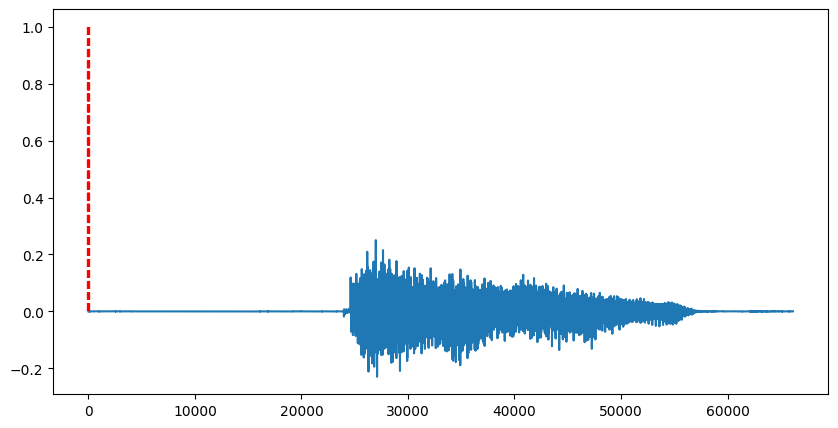

In [250]:
all_data = np.array(all_data_list).flatten()
src = all_data.reshape(all_data.size) * 100
rms = librosa.feature.rms(y=src, frame_length=2048, hop_length=hop_length, center=True)
onset_envelope = rms[0, 1:] - rms[0, :-1]
onset_envelope = np.maximum(0.0, onset_envelope)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(result_array[0], label='onset envelope')
ax.vlines(detected_onset_time, 0, 1, color='r', linestyle='--', label='onsets')

plt.show()

In [115]:
np.round(np.array(detected_onset_time) * sr).astype("int")

array([], dtype=int32)

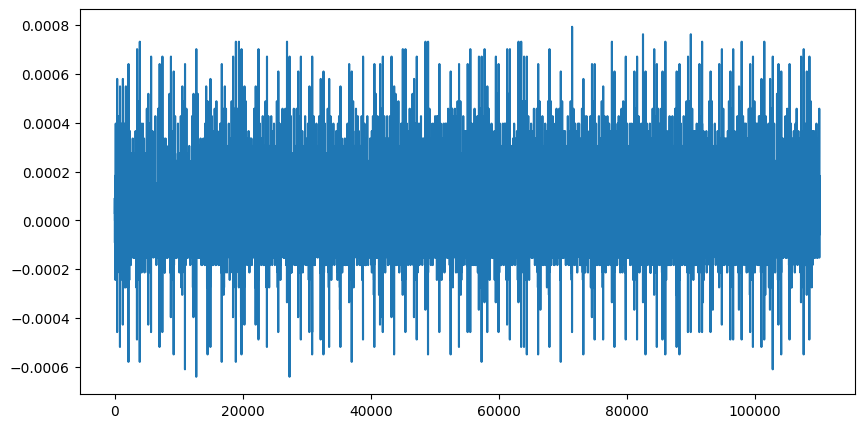

In [116]:
all_data = np.array(all_data_list).flatten()
src = all_data.reshape(all_data.size) * 100
rms = librosa.feature.rms(y=src, frame_length=2048, hop_length=hop_length, center=True)
onset_envelope = rms[0, 1:] - rms[0, :-1]
onset_envelope = np.maximum(0.0, onset_envelope)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(all_data, label='onset envelope')
ax.vlines(np.round(np.array(detected_onset_time) * sr).astype("int"), 0, 1, color='r', linestyle='--', label='onsets')

plt.show()

In [118]:
len(all_data_list[0])

576

In [19]:
fs = 44100
duration = 5

data = sd.rec(int(duration*fs), samplerate=fs, channels=1)
sd.wait()

In [60]:
sd.play(hoge, fs)
sd.wait()

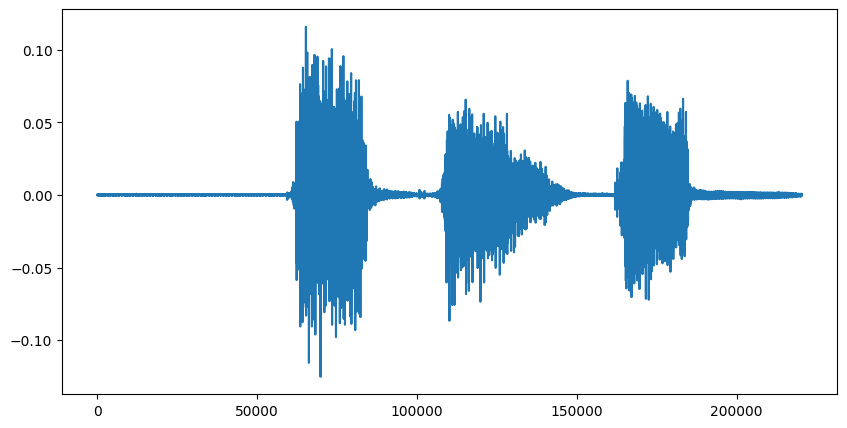

In [61]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(hoge)

plt.show()

In [25]:
shift_size = 1136
sr = 44100
hop_length = 512
pre_max = 30 / 1000 * sr // hop_length
post_max = 0 / 1000 * sr // hop_length + 1
pre_avg = 100 / 1000 * sr // hop_length
post_avg = 100 / 1000 * sr // hop_length + 1
wait = 300 / 1000 * sr // hop_length
#delta = 0.07
delta = 0.4
onset_frames = []
detected_onset_time = []
non_negative_data = np.zeros(int(44100), dtype=np.float32)


src = data.reshape(data.size) * 100
rms = librosa.feature.rms(y=src, frame_length=2048, hop_length=hop_length, center=True)
onset_envelope = rms[0, 1:] - rms[0, :-1]
onset_envelope = np.maximum(0.0, onset_envelope)
onset_frames = librosa.util.peak_pick(onset_envelope, pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)

times = librosa.times_like(onset_envelope, sr=sr)

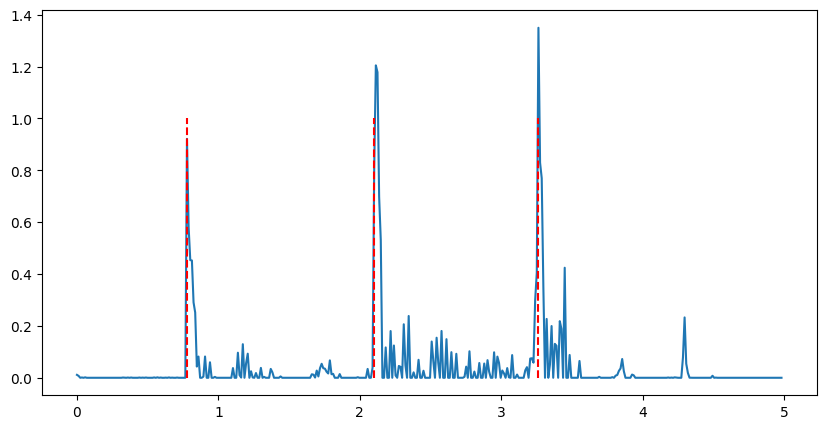

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

ax.plot(times, onset_envelope, label='onset envelope')
ax.vlines(times[onset_frames], 0, 1, color='r', linestyle='--', label='onsets')

plt.show()

In [44]:
from multiprocessing import Value, Array, Process